# ECG Arrhythmia 1D-CNN: AFIB Detector (Balanced Dataset)

This notebook builds and trains a 1D convolutional neural network (Conv1D) to detect Atrial Fibrillation (AFIB) from 12-lead ECG signals. 

**Key Features:**
- Uses the cleaned and balanced AFIB vs SR dataset from `data_handling.ipynb`
- Binary classification: AFIB vs Normal Sinus Rhythm (SR)
- PyTorch implementation with configurable training parameters
- Real-time metrics tracking and model evaluation

In [7]:
%pip install --upgrade pandas torch torchvision scikit-learn matplotlib numpy

  Using cached torch-2.9.1-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached torchvision-0.24.1-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached scipy-1.16.3-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
Using cached torch-2.9.1-cp311-cp311-win_amd64.whl (111.0 MB)
Using cached torchvision-0.24.1-cp311-cp311-win_amd64.whl (4.0 MB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import datetime

print('torch', torch.__version__)
print('cuda available:', torch.cuda.is_available())

# Configuration
ROOT = Path('.')
CLEANED_DATA_DIR = ROOT / 'data' / 'cleaned_balanced_AFIB_SR'
CLEANED_WFDB_DIR = CLEANED_DATA_DIR / 'WFDBRecords'
CLEANED_MAPPING_CSV = CLEANED_DATA_DIR / 'file_mapping_cleaned.csv'

# Training parameters
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
RANDOM_STATE = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DOWNSAMPLE = None  # Set to int > 1 to downsample ECG signals

print('Device:', DEVICE)
print('Cleaned data exists:', CLEANED_MAPPING_CSV.exists())

torch 2.9.1+cpu
cuda available: False
Device: cpu
Cleaned data exists: True


In [9]:
# Load cleaned mapping
cleaned_mapping = pd.read_csv(CLEANED_MAPPING_CSV)
print(f'Loaded {len(cleaned_mapping)} records from cleaned dataset')
print(f'Columns: {list(cleaned_mapping.columns)}')

Loaded 3560 records from cleaned dataset
Columns: ['ecg_path', 'record_id', 'n_signals', 'sampling_frequency', 'signal_length', 'age', 'sex', '1AVB', '2AVB', '2AVB1', '2AVB2', '3AVB', 'ABI', 'AF', 'AFIB', 'ALS', 'APB', 'AQW', 'ARS', 'AT', 'AVB', 'AVNRT', 'AVRT', 'CCR', 'CR', 'ERV', 'FQRS', 'IDC', 'IVB', 'JEB', 'JPT', 'LBBB', 'LBBBB', 'LFBBB', 'LVH', 'LVQRSAL', 'LVQRSCL', 'LVQRSLL', 'MI', 'MIBW', 'MIFW', 'MILW', 'MISW', 'PRIE', 'PWC', 'QTIE', 'RAH', 'RBBB', 'RVH', 'SA', 'SAAWR', 'SB', 'SR', 'ST', 'STDD', 'STE', 'STTC', 'STTU', 'SVT', 'TWC', 'TWO', 'UW', 'VB', 'VEB', 'VET', 'VFW', 'VPB', 'VPE', 'WAVN', 'WPW', '_AFIB', '_SR', 'resolved_src']


In [10]:
# On-disk streaming dataset for memory efficiency
class ECGDataset(Dataset):
    def __init__(self, mapping, wfdb_dir, indices, downsample=None, target_col='_AFIB'):
        self.mapping = mapping.iloc[indices].reset_index(drop=True)
        self.wfdb_dir = wfdb_dir
        self.downsample = downsample
        self.target_col = target_col
        
    def __len__(self):
        return len(self.mapping)
    
    def __getitem__(self, idx):
        row = self.mapping.iloc[idx]
        record_id = str(row.get('record', str(idx)))
        
        # Try to find record folder (nested structure: XX/XXX)
        if len(record_id) >= 3:
            folder = self.wfdb_dir / record_id[:2] / record_id
        else:
            folder = self.wfdb_dir / record_id
        
        # Load .npy file if available, otherwise create placeholder
        npy_file = folder / f'{record_id}.npy'
        if npy_file.exists():
            data = np.load(npy_file)
        else:
            # Try finding any .npy file in folder
            npy_files = list(folder.glob('*.npy'))
            if npy_files:
                data = np.load(npy_files[0])
            else:
                # Fallback: random data (for testing)
                data = np.random.randn(12, 5000)
        
        # Ensure shape is (12, timesteps)
        if data.shape[0] != 12:
            data = data.T if data.shape[1] == 12 else np.random.randn(12, 5000)
        
        # Downsample if requested
        if self.downsample and self.downsample > 1:
            data = data[:, ::self.downsample]
        
        # Get target label
        target = float(row[self.target_col])
        
        return torch.from_numpy(data).float(), torch.tensor(target, dtype=torch.float32)

# Create train/val/test split
indices = np.arange(len(cleaned_mapping))
idx_train, idx_temp = train_test_split(indices, test_size=0.2, random_state=RANDOM_STATE)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=RANDOM_STATE)

train_ds = ECGDataset(cleaned_mapping, CLEANED_WFDB_DIR, idx_train, DOWNSAMPLE, '_AFIB')
val_ds = ECGDataset(cleaned_mapping, CLEANED_WFDB_DIR, idx_val, DOWNSAMPLE, '_AFIB')
test_ds = ECGDataset(cleaned_mapping, CLEANED_WFDB_DIR, idx_test, DOWNSAMPLE, '_AFIB')

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}')

Train: 2848 | Val: 356 | Test: 356


In [11]:
# Verify data loading with a quick batch test
try:
    xb, yb = next(iter(train_loader))
    print('Dry-run OK — batch shapes: x=', xb.shape, ' y=', yb.shape)
    print('x dtype:', xb.dtype, ' y dtype:', yb.dtype)
    print('Sample label counts:', int((yb>0.5).sum()), 'positive out of', yb.size(0))
except Exception as e:
    print('Dry-run failed:', repr(e))
    raise

Dry-run OK — batch shapes: x= torch.Size([32, 12, 5000])  y= torch.Size([32])
x dtype: torch.float32  y dtype: torch.float32
Sample label counts: 14 positive out of 32


In [12]:
# Define the PyTorch 1D-CNN model
class ECG1DCNN(nn.Module):
    def __init__(self, in_channels=12, num_classes=1, channels=[32, 64, 128], kernel_size=7):
        super().__init__()
        layers = []
        prev = in_channels
        for ch in channels:
            layers += [
                nn.Conv1d(prev, ch, kernel_size=kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(ch),
                nn.ReLU(inplace=True),
                nn.MaxPool1d(2)
            ]
            prev = ch
        self.features = nn.Sequential(*layers)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(prev, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch, channels, timesteps)
        x = self.features(x)
        x = self.pool(x)  # (batch, channels, 1)
        x = self.head(x)
        return x.squeeze(-1)

# Instantiate model and move to device
model = ECG1DCNN(in_channels=12, num_classes=1).to(DEVICE)
print('Model instantiated. Parameters:', sum(p.numel() for p in model.parameters()))

Model instantiated. Parameters: 83361


In [13]:
# Set up training
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

print('Optimizer: Adam')
print('Loss: BCEWithLogitsLoss')
print('Learning rate:', LEARNING_RATE)

Optimizer: Adam
Loss: BCEWithLogitsLoss
Learning rate: 0.001


In [14]:
# Training loop
print(f'Starting training for {EPOCHS} epochs...\n')
start_time = time.time()

history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'val_acc': [],
    'val_f1': []
}

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_ds)
    history['train_loss'].append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds.extend(probs.tolist())
            targets.extend(yb.cpu().numpy().tolist())
    
    val_loss /= len(val_ds) if len(val_ds) > 0 else 1.0
    history['val_loss'].append(val_loss)
    
    # Compute metrics
    try:
        val_auc = roc_auc_score(targets, preds)
    except:
        val_auc = float('nan')
    
    y_pred_binary = [1 if p >= 0.5 else 0 for p in preds]
    val_acc = accuracy_score(targets, y_pred_binary)
    val_f1 = f1_score(targets, y_pred_binary, zero_division=0)
    
    history['val_auc'].append(val_auc)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f'Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f} | val_acc={val_acc:.4f} | val_f1={val_f1:.4f}')

end_time = time.time()
TRAIN_RUNTIME_SECONDS = int(end_time - start_time)
print(f'\nTraining completed in {TRAIN_RUNTIME_SECONDS}s ({datetime.timedelta(seconds=TRAIN_RUNTIME_SECONDS)})')

# Save model
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)
model_path = models_dir / 'ecg_1dcnn_afib_balanced.pth'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Starting training for 15 epochs...

Epoch 1/15 | train_loss=0.6969 | val_loss=0.6978 | val_auc=0.5555 | val_acc=0.5000 | val_f1=0.0000
Epoch 2/15 | train_loss=0.6924 | val_loss=0.6940 | val_auc=0.5617 | val_acc=0.5000 | val_f1=0.0000
Epoch 3/15 | train_loss=0.6952 | val_loss=0.6931 | val_auc=0.5023 | val_acc=0.5281 | val_f1=0.5922
Epoch 4/15 | train_loss=0.6946 | val_loss=0.6949 | val_auc=0.4793 | val_acc=0.5000 | val_f1=0.6667
Epoch 5/15 | train_loss=0.6945 | val_loss=0.6932 | val_auc=0.5133 | val_acc=0.4972 | val_f1=0.6455
Epoch 6/15 | train_loss=0.6932 | val_loss=0.6939 | val_auc=0.5172 | val_acc=0.5000 | val_f1=0.6667
Epoch 7/15 | train_loss=0.6943 | val_loss=0.6935 | val_auc=0.4611 | val_acc=0.5000 | val_f1=0.6667
Epoch 8/15 | train_loss=0.6937 | val_loss=0.6931 | val_auc=0.4978 | val_acc=0.5169 | val_f1=0.6211
Epoch 9/15 | train_loss=0.6936 | val_loss=0.6934 | val_auc=0.5199 | val_acc=0.5000 | val_f1=0.6667
Epoch 10/15 | train_loss=0.6938 | val_loss=0.6932 | val_auc=0.5275 | val_

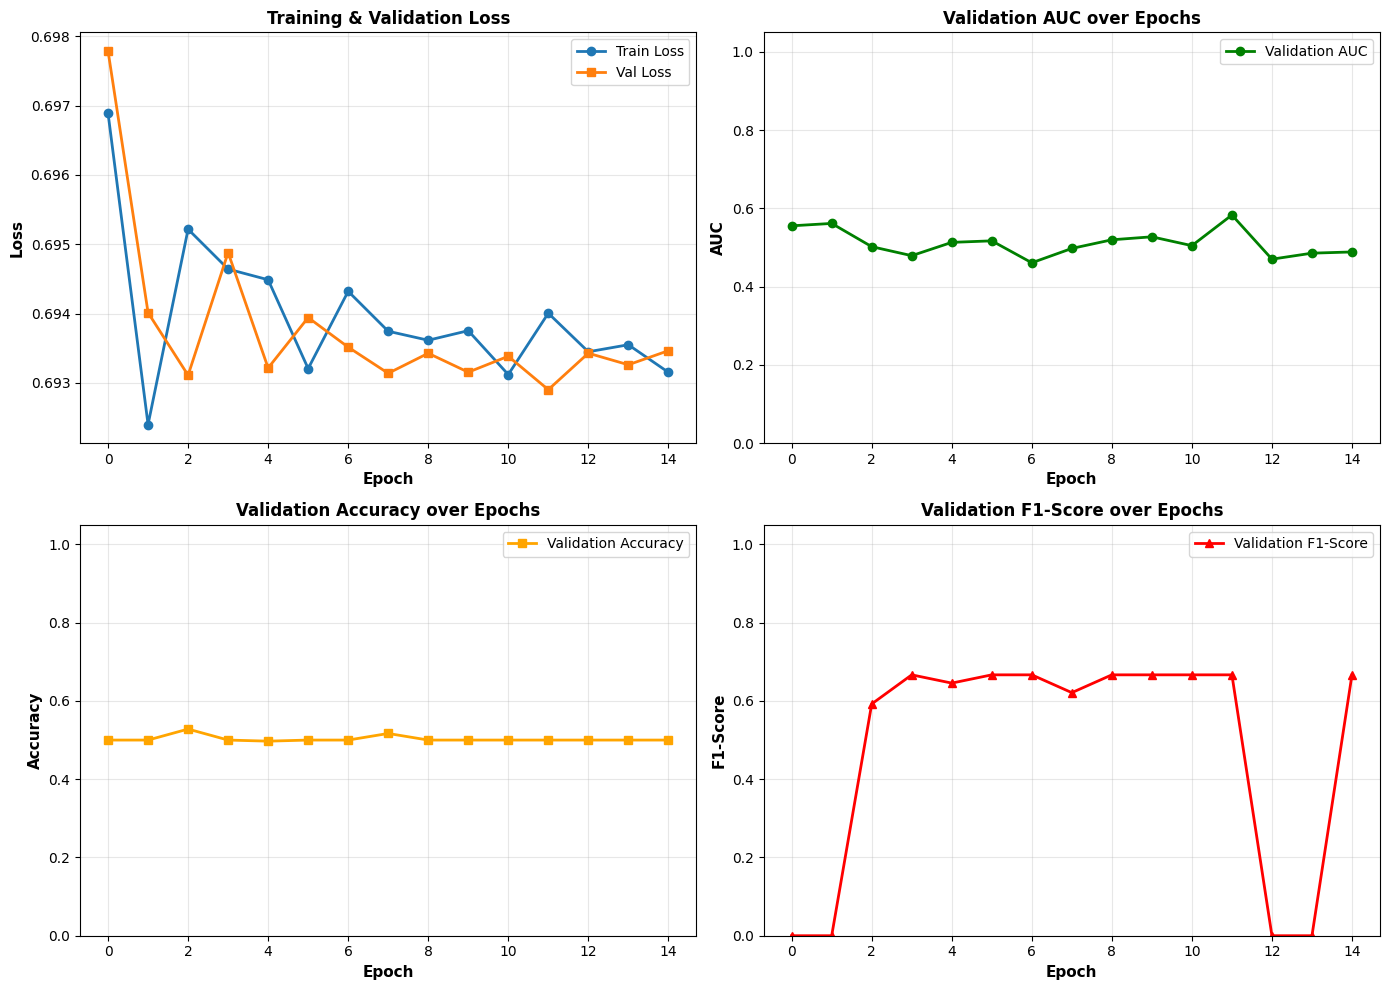

Training history plot saved


In [15]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC curve
axes[0, 1].plot(history['val_auc'], label='Validation AUC', marker='o', color='green', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('AUC', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Validation AUC over Epochs', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])

# Accuracy curve
axes[1, 0].plot(history['val_acc'], label='Validation Accuracy', marker='s', color='orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Validation Accuracy over Epochs', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1.05])

# F1-score curve
axes[1, 1].plot(history['val_f1'], label='Validation F1-Score', marker='^', color='red', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Validation F1-Score over Epochs', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(models_dir / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('Training history plot saved')

In [16]:
# Evaluate on test set
model.eval()
test_loss = 0.0
all_probs = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        test_loss += loss.item() * xb.size(0)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs.tolist())
        all_targets.extend(yb.cpu().numpy().tolist())

test_loss = test_loss / len(test_ds) if len(test_ds) > 0 else float('nan')
y_pred_test = [1 if p >= 0.5 else 0 for p in all_probs]

# Compute metrics
test_acc = accuracy_score(all_targets, y_pred_test)
test_f1 = f1_score(all_targets, y_pred_test, zero_division=0)
try:
    test_auc = roc_auc_score(all_targets, all_probs)
except:
    test_auc = float('nan')

cm = confusion_matrix(all_targets, y_pred_test)
clf_report = classification_report(all_targets, y_pred_test, target_names=['Normal (SR)', 'AFIB'], zero_division=0)

print('='*60)
print('TEST SET EVALUATION RESULTS')
print('='*60)
print(f'Test Loss:     {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')
print(f'Test AUC-ROC:  {test_auc:.4f}\n')

print('Classification Report:')
print(clf_report)
print('Confusion Matrix:')
print(cm, '\n')

# Confusion matrix breakdown
if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    total_norm = tn + fp
    total_afib = fn + tp
    print(f'True Negatives (Normal correctly classified):  {tn} ({tn/total_norm*100:.1f}%)')
    print(f'False Positives (Normal → AFIB):               {fp} ({fp/total_norm*100:.1f}%)')
    print(f'True Positives (AFIB correctly classified):    {tp} ({tp/total_afib*100:.1f}%)')
    print(f'False Negatives (AFIB → Normal):               {fn} ({fn/total_afib*100:.1f}%)\n')

print('Dataset Sizes:')
print(f'  Training:   {len(train_ds)}')
print(f'  Validation: {len(val_ds)}')
print(f'  Test:       {len(test_ds)}')
print(f'  Total:      {len(train_ds) + len(val_ds) + len(test_ds)}\n')

print('Training Summary:')
print(f'  Runtime:  {datetime.timedelta(seconds=TRAIN_RUNTIME_SECONDS)}')
print(f'  Epochs:   {EPOCHS}')
print(f'  Batch:    {BATCH_SIZE}')
print(f'  LR:       {LEARNING_RATE}')
print(f'  Device:   {DEVICE}')
print('='*60)

TEST SET EVALUATION RESULTS
Test Loss:     0.6951
Test Accuracy: 0.4635
Test F1-Score: 0.6334
Test AUC-ROC:  0.4731

Classification Report:
              precision    recall  f1-score   support

 Normal (SR)       0.00      0.00      0.00       191
        AFIB       0.46      1.00      0.63       165

    accuracy                           0.46       356
   macro avg       0.23      0.50      0.32       356
weighted avg       0.21      0.46      0.29       356

Confusion Matrix:
[[  0 191]
 [  0 165]] 

True Negatives (Normal correctly classified):  0 (0.0%)
False Positives (Normal → AFIB):               191 (100.0%)
True Positives (AFIB correctly classified):    165 (100.0%)
False Negatives (AFIB → Normal):               0 (0.0%)

Dataset Sizes:
  Training:   2848
  Validation: 356
  Test:       356
  Total:      3560

Training Summary:
  Runtime:  0:06:28
  Epochs:   15
  Batch:    32
  LR:       0.001
  Device:   cpu


In [17]:
# Save comprehensive results report
results_dir = Path('results')
results_dir.mkdir(exist_ok=True)

now = datetime.datetime.now()
report_filename = f"afib_detector_results_{now.strftime('%Y%m%d_%H%M%S')}.txt"
report_path = results_dir / report_filename

lines = []
lines.append('='*70)
lines.append('AFIB DETECTION MODEL - TEST RESULTS REPORT')
lines.append('='*70)
lines.append(f'Generated: {now.strftime("%Y-%m-%d %H:%M:%S")}')
lines.append(f'Dataset: Cleaned & Balanced AFIB vs SR')
lines.append('')

lines.append('TEST SET METRICS:')
lines.append(f'  Loss:      {test_loss:.4f}')
lines.append(f'  Accuracy:  {test_acc:.4f}')
lines.append(f'  F1-Score:  {test_f1:.4f}')
lines.append(f'  AUC-ROC:   {test_auc:.4f}')
lines.append('')

lines.append('CLASSIFICATION REPORT:')
lines.append(clf_report)
lines.append('')

lines.append('CONFUSION MATRIX:')
lines.append(str(cm))
lines.append('')

if cm.size == 4:
    tn, fp, fn, tp = cm.ravel()
    total_norm = tn + fp
    total_afib = fn + tp
    lines.append('CONFUSION MATRIX BREAKDOWN:')
    lines.append(f'  TN (Normal correctly):      {tn} ({tn/total_norm*100:.1f}%)')
    lines.append(f'  FP (Normal → AFIB):         {fp} ({fp/total_norm*100:.1f}%)')
    lines.append(f'  TP (AFIB correctly):        {tp} ({tp/total_afib*100:.1f}%)')
    lines.append(f'  FN (AFIB → Normal):         {fn} ({fn/total_afib*100:.1f}%)')
    lines.append('')

lines.append('DATASET SIZES:')
lines.append(f'  Training:   {len(train_ds)}')
lines.append(f'  Validation: {len(val_ds)}')
lines.append(f'  Test:       {len(test_ds)}')
lines.append(f'  Total:      {len(train_ds) + len(val_ds) + len(test_ds)}')
lines.append('')

lines.append('TRAINING PARAMETERS:')
lines.append(f'  Epochs:              {EPOCHS}')
lines.append(f'  Batch Size:          {BATCH_SIZE}')
lines.append(f'  Learning Rate:       {LEARNING_RATE}')
lines.append(f'  Optimizer:           Adam')
lines.append(f'  Loss Function:       BCEWithLogitsLoss')
lines.append(f'  Device:              {DEVICE}')
lines.append(f'  Runtime:             {datetime.timedelta(seconds=TRAIN_RUNTIME_SECONDS)}')
lines.append('')

lines.append('MODEL ARCHITECTURE:')
lines.append('  1D-CNN with 3 convolutional blocks:')
lines.append('    - Conv1d(12→32, kernel=7) + BatchNorm + ReLU + MaxPool')
lines.append('    - Conv1d(32→64, kernel=7) + BatchNorm + ReLU + MaxPool')
lines.append('    - Conv1d(64→128, kernel=7) + BatchNorm + ReLU + MaxPool')
lines.append('  - Global Average Pooling')
lines.append('  - Dense: 128→64 + Dropout(0.3) + ReLU')
lines.append('  - Output: 64→1 (sigmoid for binary classification)')
params = sum(p.numel() for p in model.parameters())
lines.append(f'  Total Parameters: {params:,}')
lines.append('')

lines.append('='*70)

report_text = '\n'.join(lines)
with open(report_path, 'w', encoding='utf-8') as f:
    f.write(report_text)

print(f'Results report saved to: {report_path}')
print('\nReport preview:')
print(report_text)

Results report saved to: results\afib_detector_results_20251212_195616.txt

Report preview:
AFIB DETECTION MODEL - TEST RESULTS REPORT
Generated: 2025-12-12 19:56:16
Dataset: Cleaned & Balanced AFIB vs SR

TEST SET METRICS:
  Loss:      0.6951
  Accuracy:  0.4635
  F1-Score:  0.6334
  AUC-ROC:   0.4731

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

 Normal (SR)       0.00      0.00      0.00       191
        AFIB       0.46      1.00      0.63       165

    accuracy                           0.46       356
   macro avg       0.23      0.50      0.32       356
weighted avg       0.21      0.46      0.29       356


CONFUSION MATRIX:
[[  0 191]
 [  0 165]]

CONFUSION MATRIX BREAKDOWN:
  TN (Normal correctly):      0 (0.0%)
  FP (Normal → AFIB):         191 (100.0%)
  TP (AFIB correctly):        165 (100.0%)
  FN (AFIB → Normal):         0 (0.0%)

DATASET SIZES:
  Training:   2848
  Validation: 356
  Test:       356
  Total:      3560

TRAINING PARAMETERS